In [14]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.linalg import expm, eigh  # Use scipy for the matrix exponential function

class Simulator:
    def __init__(self, N, H):
        self.N = N
        self.H = H
        
    def classical(self):
        """Simulate the system classically."""
        best_energy = float('inf')
        best_config = None

        # Brute-force over all spin configurations
        for config in range(1 << self.N):
            spins = [1 if (config & (1 << i)) else -1 for i in range(self.N)]
            energy = self.H(spins)
            # print(f"Config {config}: Spins = {spins}, Energy = {energy}")
            if energy < best_energy:
                best_energy = energy
                best_config = spins


        return best_config, best_energy
    
    def compute_eigenvalues(self):
        """Compute all possible eigenvalues of the Hamiltonian."""
        eigenvalues = set()
        for config in range(1 << self.N):
            spins = [1 if (config & (1 << i)) else -1 for i in range(self.N)]
            eigenvalue = self.H(spins)
            eigenvalues.add(eigenvalue)
        return sorted(eigenvalues)
    
    def suggest_t(self):
        """Suggest an optimal time t based on the energy gap."""
        eigenvalues = self.compute_eigenvalues()
        if len(eigenvalues) < 2:
            raise ValueError("Insufficient eigenvalues to compute energy gap.")

        gaps = [eigenvalues[i + 1] - eigenvalues[i] for i in range(len(eigenvalues) - 1)]
        delta_E = min(gaps)
        return self.N / (delta_E ** 2)  # Suggest t proportional to the inverse gap
    
    def adiabatic_evolution(simulator, num_steps=100, T=10, backward=False):
        """
        Simulates adiabatic evolution with a transverse field as the initial Hamiltonian.

        Parameters:
            simulator (Simulator): Instance of the simulator.
            num_steps (int): Number of time steps for the evolution.
            T (float): Total time for the evolution.
            backward (bool): If True, evolve backward from final to initial Hamiltonian.

        Returns:
            - states_over_time: List of state vectors at each step.
            - H_ts_over_time: List of instantaneous Hamiltonians at each step.
            - final_state: Final state vector after evolution.
        """
        num_states = 2**simulator.N
        H_initial = np.zeros((num_states, num_states), dtype=complex)

        # Construct the transverse field Hamiltonian
        for i in range(simulator.N):
            for config in range(num_states):
                flipped_config = config ^ (1 << i)  # Flip the i-th spin
                H_initial[config, flipped_config] = -1  # Pauli-X equivalent

        H_final = np.zeros((num_states, num_states), dtype=complex)

        # Construct the target (final) Hamiltonian matrix
        for config in range(num_states):
            spins = [1 if (config & (1 << i)) else -1 for i in range(simulator.N)]
            energy = simulator.H(spins)
            H_final[config, config] = energy

        # Reverse time points for backward evolution
        if backward:
            time_points = np.linspace(T, 0, num_steps)
            current_state = np.ones(num_states, dtype=complex) / np.sqrt(num_states)  # Reset state
        else:
            time_points = np.linspace(0, T, num_steps)
            current_state = np.ones(num_states, dtype=complex) / np.sqrt(num_states)  # Initial state

        states_over_time = []
        H_ts_over_time = []

        for t in time_points:
            s = t / T if not backward else (T - t) / T
            H_t = (1 - s) * H_initial + s * H_final  # Interpolate Hamiltonian
            U = expm(-1j * H_t * (T / num_steps))  # Evolution operator for small step
            current_state = U @ current_state  # Apply the evolution

            states_over_time.append((t, current_state))
            H_ts_over_time.append((t, H_t))

        # Return the list of states, Hamiltonians, and the final state
        return states_over_time, H_ts_over_time, current_state
    
    def adiabatic_evolution_with_return(simulator, num_steps=100, T=10):
        """
        Simulates adiabatic evolution starting from H_initial to H_final, then back to H_initial.

        Parameters:
            simulator (Simulator): Instance of the simulator.
            num_steps (int): Number of time steps for the forward and backward evolution.
            T (float): Total time for each phase (forward and backward).

        Returns:
            - states_over_time: List of state vectors at each step.
            - H_ts_over_time: List of instantaneous Hamiltonians at each step.
            - final_state: Final state vector after backward evolution.
        """
        num_states = 2**simulator.N
        H_initial = np.zeros((num_states, num_states), dtype=complex)

        # Construct the transverse field Hamiltonian
        for i in range(simulator.N):
            for config in range(num_states):
                flipped_config = config ^ (1 << i)  # Flip the i-th spin
                H_initial[config, flipped_config] = -1  # Pauli-X equivalent

        H_final = np.zeros((num_states, num_states), dtype=complex)

        # Construct the target (final) Hamiltonian matrix
        for config in range(num_states):
            spins = [1 if (config & (1 << i)) else -1 for i in range(simulator.N)]
            energy = simulator.H(spins)
            H_final[config, config] = energy

        # Adiabatic evolution states
        states_over_time = []
        H_ts_over_time = []

        # Forward evolution: H_initial -> H_final
        time_points_forward = np.linspace(0, T, num_steps)
        current_state = np.ones(num_states, dtype=complex) / np.sqrt(num_states)  # Initial state

        for t in time_points_forward:
            s = t / T
            H_t = (1 - s) * H_initial + s * H_final  # Interpolate Hamiltonian
            U = expm(-1j * H_t * (T / num_steps))  # Evolution operator
            current_state = U @ current_state  # Apply the evolution

            states_over_time.append((t, current_state))
            H_ts_over_time.append((t, H_t))

        # Backward evolution: H_final -> H_initial
        time_points_backward = np.linspace(T, 2 * T, num_steps)
        for t in time_points_backward:
            s = (t - T) / T
            H_t = (1 - s) * H_final + s * H_initial  # Interpolate Hamiltonian
            U = expm(-1j * H_t * (T / num_steps))  # Evolution operator
            current_state = U @ current_state  # Apply the evolution

            states_over_time.append((t, current_state))
            H_ts_over_time.append((t, H_t))

        # Return the list of states, Hamiltonians, and the final state
        return states_over_time, H_ts_over_time, current_state


    def compute_overlaps(self, states_over_time, H_ts_over_time):
        """Compute the overlap of the current state with the instantaneous ground state."""
        overlaps = []
        for (t, state), (t_H, H_t) in zip(states_over_time, H_ts_over_time):
            _, eigenvectors = eigh(H_t)  # Compute eigenstates
            ground_state = eigenvectors[:, 0]  # Ground state
            overlap = np.abs(np.dot(np.conjugate(ground_state), state))**2
            overlaps.append((t, overlap))
        return overlaps

In [15]:
def measure(final_state, simulator, shots=10000):
    """
    Measure the final quantum state and return the most frequently observed spin configuration and its energy.
    :param final_state: The final quantum state as a complex vector.
    :param simulator: The simulator instance for energy calculation.
    :param shots: Number of measurements to simulate.
    :return: The most frequently observed spin configuration and its energy.
    """
    # Compute probabilities for each configuration
    probabilities = np.abs(final_state)**2
    probabilities /= np.sum(probabilities)  # Normalize

    # Perform sampling based on probabilities
    sampled_indices = np.random.choice(len(probabilities), size=shots, p=probabilities)

    # Count the occurrences of each index
    unique, counts = np.unique(sampled_indices, return_counts=True)
    most_frequent_index = unique[np.argmax(counts)]

    # Convert the most frequent index to a spin configuration
    spins = [1 if (most_frequent_index & (1 << i)) else -1 for i in range(simulator.N)]

    # Calculate the energy for the most frequently observed spin configuration
    energy = simulator.H(spins)

    # Debugging: Print details of the measurement
    print(f"Most Frequent Index: {most_frequent_index}")
    print(f"Most Frequent Spins: {spins}")
    print(f"Most Frequent Energy: {energy}")

    return spins, energy

In [16]:
class TravelingSalesman:
    def __init__(self, vertices, edges, weights):
        """
        Initialize the Traveling Salesman problem.
        :param vertices: List of vertices.
        :param edges: List of edges [(u, v), ...].
        :param weights: Dictionary with edge weights {(u, v): weight, ...}.
        """
        self.vertices = vertices
        self.edges = edges
        self.weights = weights
        self.num_vertices = len(vertices)
        self.edge_set = set(edges)

    def hamiltonian(self):
        """Define the Ising Hamiltonian for the Traveling Salesman problem."""
        def hamiltonian(spins):
            # Convert spins to binary variables
            x = (np.array(spins) + 1) / 2
            x = x.reshape((self.num_vertices, self.num_vertices))  # Reshape for vertices and positions

            # Constraint 1: Each vertex appears exactly once
            H_vertex = sum((1 - np.sum(x[v, :])) ** 2 for v in range(self.num_vertices))

            # Constraint 2: Each position is occupied exactly once
            H_position = sum((1 - np.sum(x[:, j])) ** 2 for j in range(self.num_vertices))

            # Constraint 3: Penalize invalid edges
            H_invalid_edges = 0
            for u in range(self.num_vertices):
                for v in range(self.num_vertices):
                    if (u, v) not in self.edge_set:
                        for j in range(self.num_vertices - 1):
                            H_invalid_edges += x[u, j] * x[v, j + 1]

            # Objective function: Minimize weights of valid edges
            H_weight = 0
            for (u, v), weight in self.weights.items():
                for j in range(self.num_vertices - 1):
                    H_weight += weight * x[u, j] * x[v, j + 1]

            # Combine terms
            self.max_weight = max(weights.values())  # Maximum edge weight
            A = self.max_weight * self.num_vertices
            B = 1.0   # Objective weight
            return A * (H_vertex + H_position + H_invalid_edges) + B * H_weight

        return hamiltonian

In [17]:
def print_top_spin_state_probabilities(final_state, simulator, top_n=5):
    """
    Print the top N spin state probabilities from the final quantum state.
    :param final_state: The final quantum state as a complex vector.
    :param simulator: The simulator instance for energy calculation.
    :param top_n: Number of top probabilities to print.
    """
    # Compute probabilities for each configuration
    probabilities = np.abs(final_state)**2
    probabilities /= np.sum(probabilities)  # Normalize

    # Get indices sorted by probabilities in descending order
    sorted_indices = np.argsort(probabilities)[::-1]

    # Print the top N configurations
    print(f"Top {top_n} spin state probabilities:")
    for rank in range(top_n):
        index = sorted_indices[rank]
        prob = probabilities[index]
        # Convert the index to spin configuration
        spins = [1 if (index & (1 << i)) else -1 for i in range(simulator.N)]
        energy = simulator.H(spins)  # Calculate energy for this configuration
        print(f"Rank {rank + 1}: Spins = {spins}, Probability = {prob:.4f}, Energy = {energy:.4f}")



In [18]:
# vertices = [0, 1, 2, 3]
# edges = [(0, 1), (1, 2), (2, 3), (3, 0)]
# weights = {(0, 1): 1, (1, 2): 2, (2, 3): 3, (3, 0): 4}
vertices = [0, 1, 2]
edges = [(0, 1), (1, 2), (2, 0)]
weights = {(0, 1): 1, (1, 2): 2, (2, 0): 3}
num_vertices = len(vertices)
num_variables = num_vertices ** 2  # Each vertex-position pair is a variable

tsp_problem = TravelingSalesman(vertices, edges, weights)
sim = Simulator(num_vertices ** 2, tsp_problem.hamiltonian())

# Classical Simulation
classical_result = sim.classical()
print("Classical Result:", classical_result)

# Suggest an optimal t
optimal_t = sim.suggest_t()
print(f"Suggested optimal t: {optimal_t}")

# Adiabatic Simulation
states_forward, H_ts_over_time, final_state = sim.adiabatic_evolution(num_steps=200, T=optimal_t)

# Measure the final state
best_spins, best_energy = measure(final_state, sim)
# print(f"Final State: {final_state}")
print("Final State Measurement:")
print(f"Best Spins: {best_spins}")
print(f"Best Energy: {best_energy}")

# Print the top 5 spin state probabilities
print_top_spin_state_probabilities(final_state, sim, top_n=5)

# Measure the initial state after backward evolution
# initial_spins, initial_energy = measure(initial_state, sim)
# print("Initial State Measurement (Backward Evolution):")
# print(f"Initial Spins: {initial_spins}")
# print(f"Initial Energy: {initial_energy}")


Classical Result: ([1, -1, -1, -1, 1, -1, -1, -1, 1], 3.0)
Suggested optimal t: 9.0
Most Frequent Index: 273
Most Frequent Spins: [1, -1, -1, -1, 1, -1, -1, -1, 1]
Most Frequent Energy: 3.0
Final State Measurement:
Best Spins: [1, -1, -1, -1, 1, -1, -1, -1, 1]
Best Energy: 3.0
Top 5 spin state probabilities:
Rank 1: Spins = [1, -1, -1, -1, 1, -1, -1, -1, 1], Probability = 0.1772, Energy = 3.0000
Rank 2: Spins = [-1, 1, -1, -1, -1, 1, 1, -1, -1], Probability = 0.1695, Energy = 4.0000
Rank 3: Spins = [-1, -1, 1, 1, -1, -1, -1, 1, -1], Probability = 0.1605, Energy = 5.0000
Rank 4: Spins = [1, -1, -1, -1, -1, 1, -1, -1, -1], Probability = 0.0463, Energy = 18.0000
Rank 5: Spins = [-1, -1, -1, 1, -1, -1, -1, -1, 1], Probability = 0.0398, Energy = 18.0000


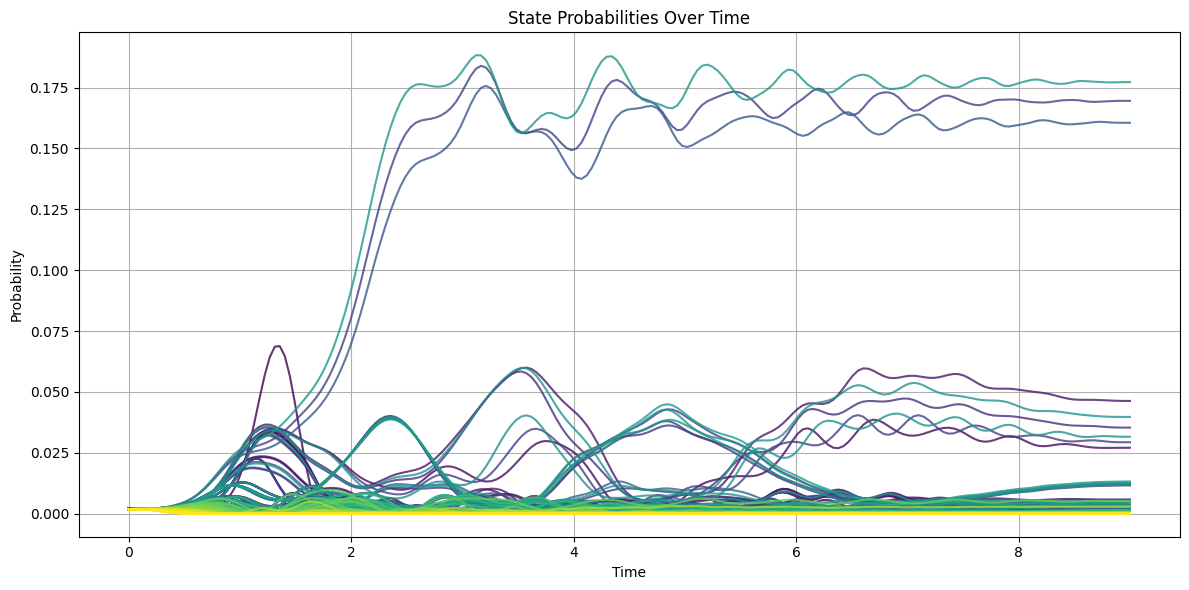

In [19]:
def plot_state_probabilities(states_over_time):
    """
    Plots the evolution of state probabilities over time.

    Parameters:
        states_over_time (list): List of tuples (time, state vector) from adiabatic evolution.
    """
    num_states = len(states_over_time[0][1])
    probabilities_over_time = []
    time_points = []

    for t, state in states_over_time:
        probabilities = np.abs(state)**2
        probabilities_over_time.append(probabilities)
        time_points.append(t)

    probabilities_over_time = np.array(probabilities_over_time)
    time_points = np.array(time_points)

    # Plot state probabilities
    plt.figure(figsize=(12, 6))
    colors = cm.viridis(np.linspace(0, 1, num_states))
    for state_idx in range(num_states):
        plt.plot(time_points, probabilities_over_time[:, state_idx], color=colors[state_idx], alpha=0.8)
    plt.title("State Probabilities Over Time")
    plt.xlabel("Time")
    plt.ylabel("Probability")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plot state probabilities
plot_state_probabilities(states_forward)